# log($X_{Wt}$)

**Goal:** By defiition, $X_{Wt}$ is a positive variable, but my first pass through this suite of validation studies was just modelling $X_{Wt}$ directly.

I probably won't be _crazy_ sensitive to this b/c the final discriminant that we have is comparing the discriminant for $X_{Wt} > 1.5$, so we're less sensitive to the modelling at $X_{Wt}$ close to 0.

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import cabinetry
cabinetry.set_logging()

import hist
import pyhf
# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
colors = [
    'dodgerblue',
    'darkorange',
    'limegreen',
    'crimson',
    'mediumpurple',
    'brown',
    'deeppink',
    'grey',
    'gold',
    'mediumturquoise'
]

**Load in the histograms with the normal cut**

In [ ]:
nSeeds = 25

yrs = ['16','17','18']

In [8]:
'''
Model Xwt
'''
c = 'val1p1'

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig1 = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

'''
Model log(Xwt)
'''
c = 'val1p1a'

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

colTag = '_'.join(hps['cols'])

modelConfig2 = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'



In [144]:
hdict = {i: {yr:{} for yr in yrs} for i in range(10)} # GP + flow prediction
hAll = {i: {} for i in range(10)}

ldict = {i: {yr:{} for yr in yrs} for i in range(10)} # GP + flow prediction
lAll = {i: {} for i in range(10)}

for i in range(10):
    
    subDir = f'data161718-MAY21_3b1f_{i}of10_detaCut_ggf'
    modelDir = f'../gp-for-flows/models/{subDir}'

    
    for yr in yrs:
        with open(f'{modelDir}/{modelConfig1}/hists_gp_100k_pipe_{yr}.json','r') as hfile:
            out1 = json.load(hfile)

        with open(f'{modelDir}/{modelConfig2}/hists_gp_100k_pipe_{yr}.json','r') as hfile:
            out2 = json.load(hfile)
            
        for k in out2.keys():
            hdict[i][yr][k] = np.array( out1[k])
            ldict[i][yr][k] = np.array( out2[k])
            
    for k in ldict[i]['18'].keys():
        if 'std' in k: 
            continue

        hAll[i][k] = np.vstack([hd[k] for yr,hd in hdict[i].items()]).sum(axis=0)
        lAll[i][k] = np.vstack([hd[k] for yr,hd in ldict[i].items()]).sum(axis=0)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
        k = f'{c}_SR{tag}'

        # Correlated errors
        stack = np.vstack([hAll[i][f'{k}_{j}'] for j in range(nSeeds)])
        hAll[i][f"{k}_std"] = np.sqrt(np.sum((stack - hAll[i][f'{k}_mean'])**2, axis=0) / (nSeeds-1))

        stack = np.vstack([lAll[i][f'{k}_{j}'] for j in range(nSeeds)])
        lAll[i][f"{k}_std"] = np.sqrt(np.sum((stack - lAll[i][f'{k}_mean'])**2, axis=0) / (nSeeds-1))   
        

**Load in the data**

In [25]:
fnames = [f'../data/RR/cryptotuples/data{yr}.root' for yr in yrs]

In [26]:
hc_vars = [f'{v}_h{i}' for v, i in product(['pT','eta','phi'],[1,2])]

load_cols = d_cols + ['ntag','X_wt_tag','pass_vbf_sel','minQ','event_number'] + hc_vars

In [27]:
myRanges,edg_3d = get_default_bins()

In [28]:
dfs = []

for fname in fnames:
    print(fname)
    with uproot.open(fname) as f:
        
        dfi = f['sig'].arrays(load_cols,library='pd')
        mi = dfi.eval('ntag == 3 & minQ == 1 & ~pass_vbf_sel')


        dfs.append( dfi[mi] )
        
df = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/data16.root
../data/RR/cryptotuples/data17.root
../data/RR/cryptotuples/data18.root


**Step 1:** C.f. the marginals(?)

In [101]:
get_default_bins()

([(200, 1200),
  (250, 1250),
  (0, 1.65),
  (0, 400),
  (0, 400),
  (-3, 3),
  (-3, 3),
  (-0.5, 3.141592653589793),
  (0, 7.5)],
 [[0, 0.95, 1.6],
  [0, 0.5, 1, inf],
  array([  0., 305., 333., 363., 395., 431., 470., 512., 558., 608., 663.,
         723., 788., 858., 936.,  inf])])

**Step 2:** C.f. the high level discriminants

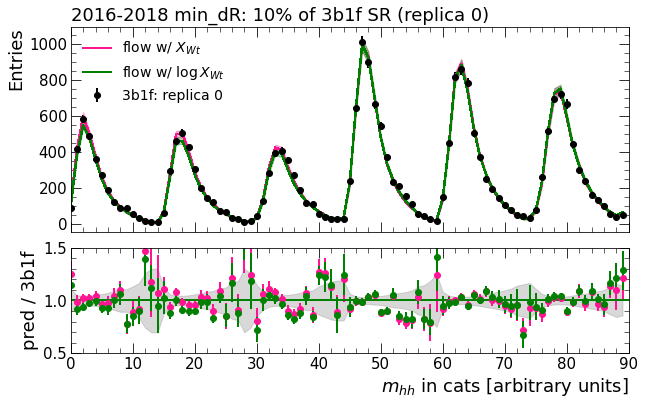

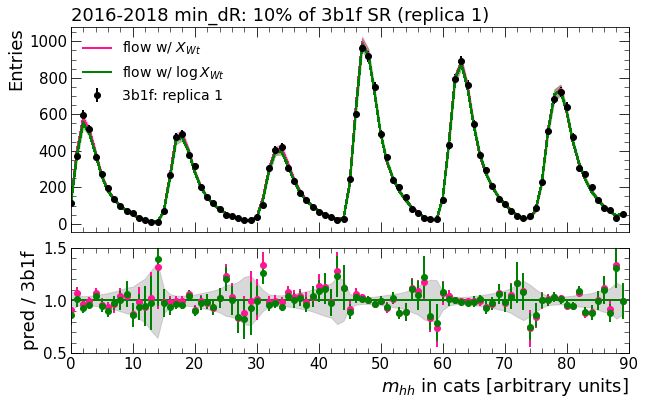

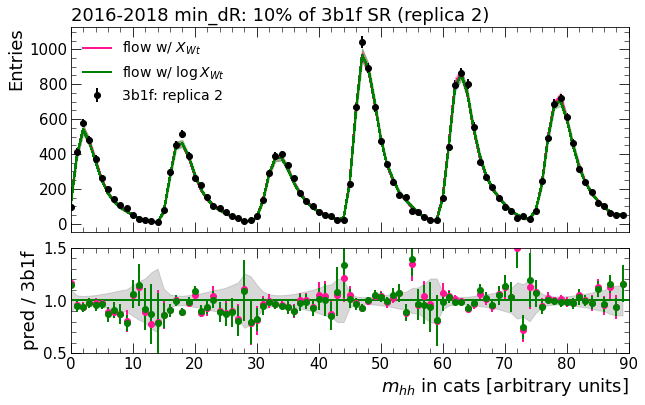

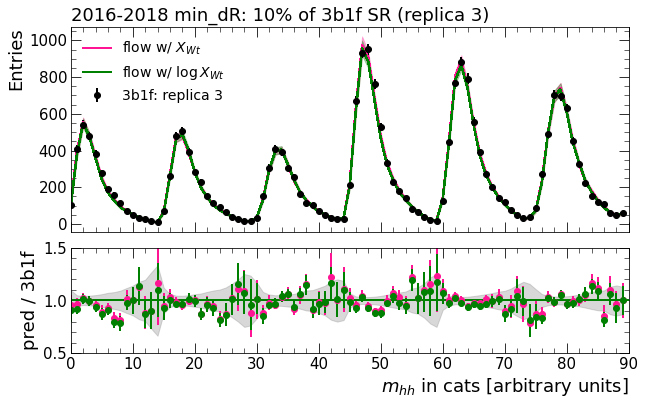

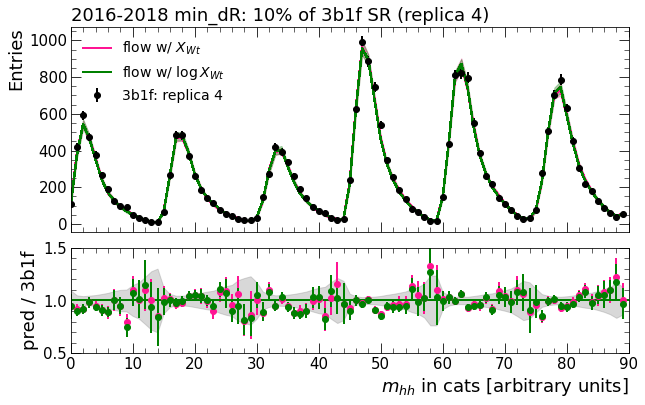

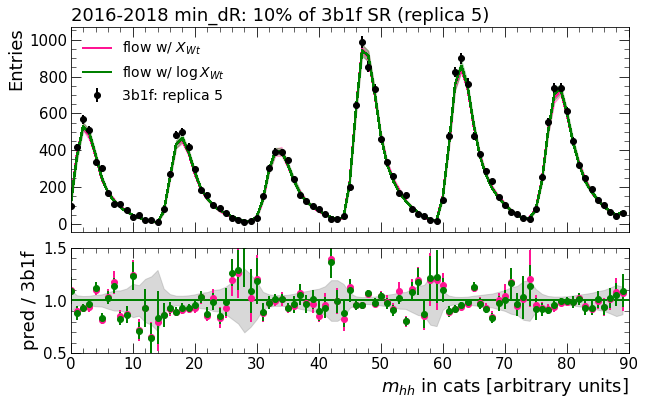

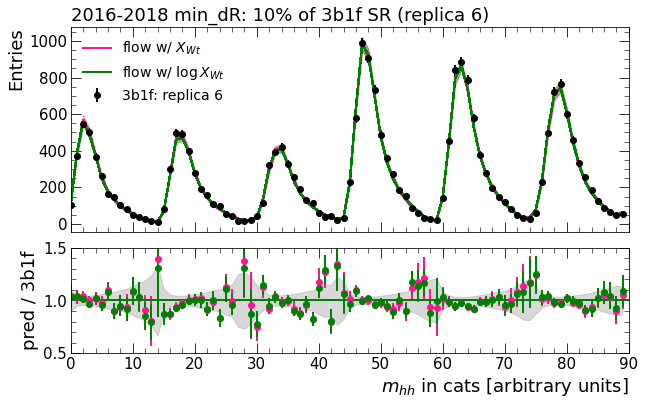

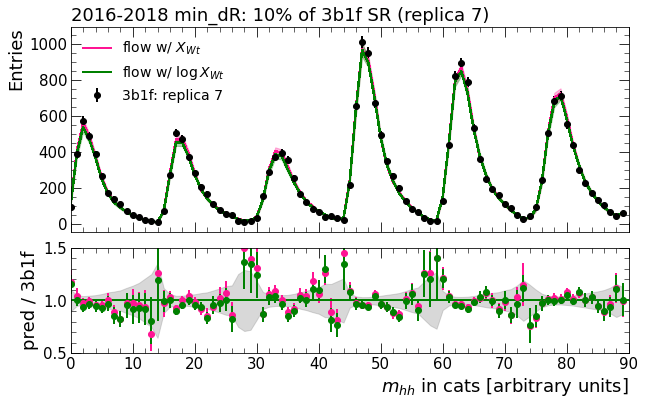

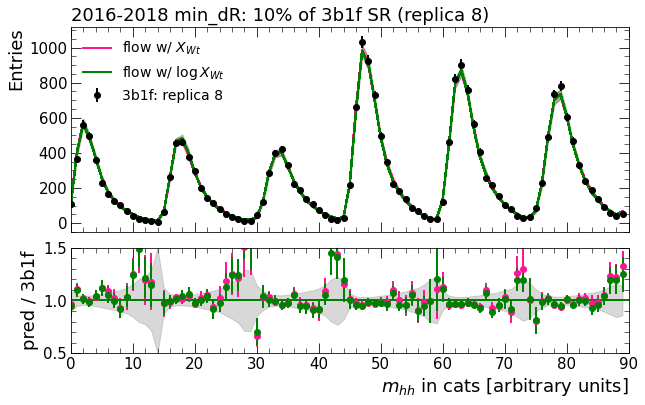

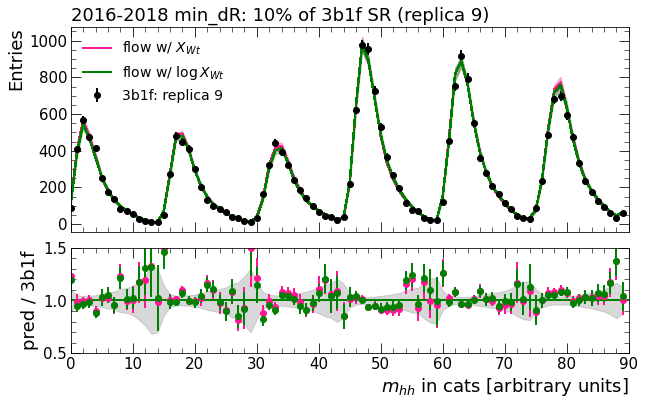

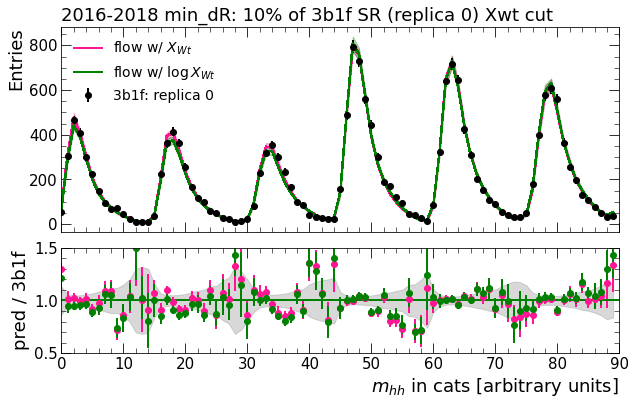

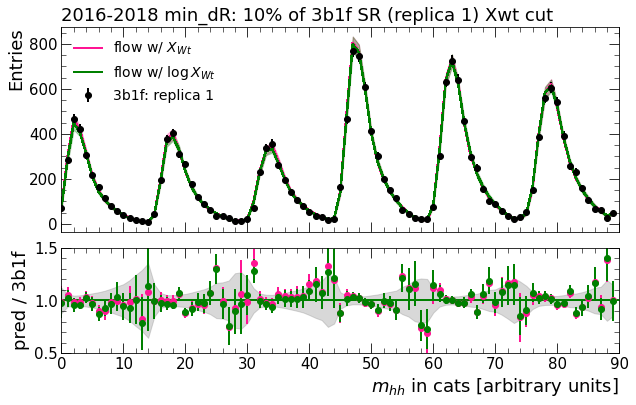

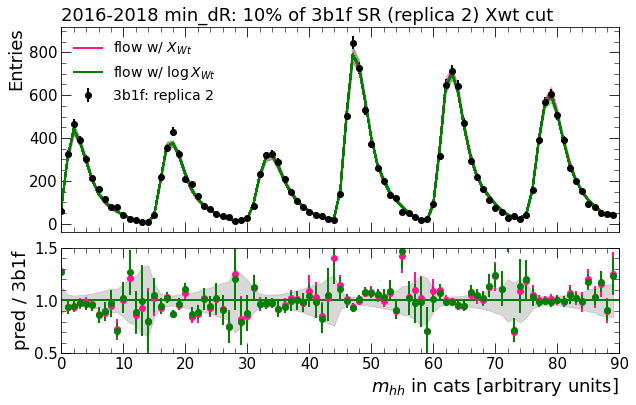

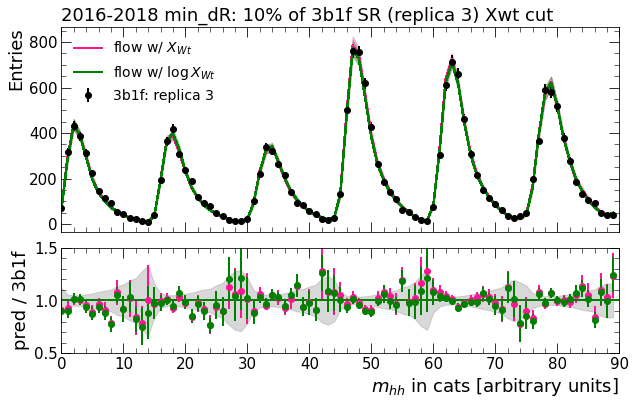

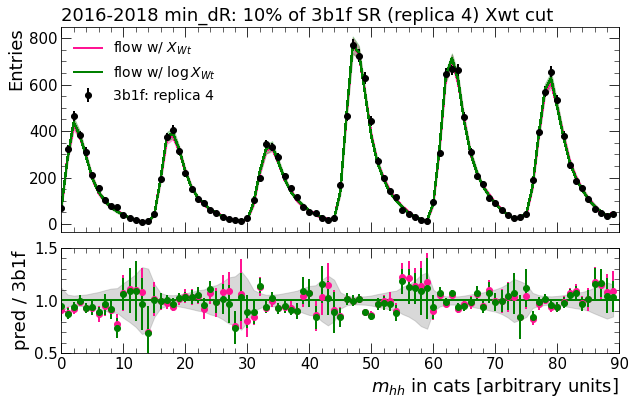

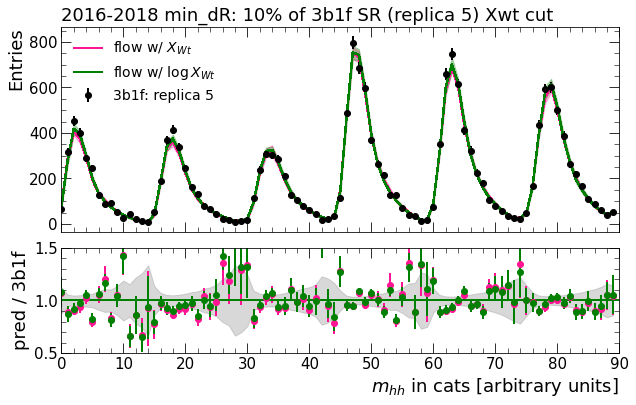

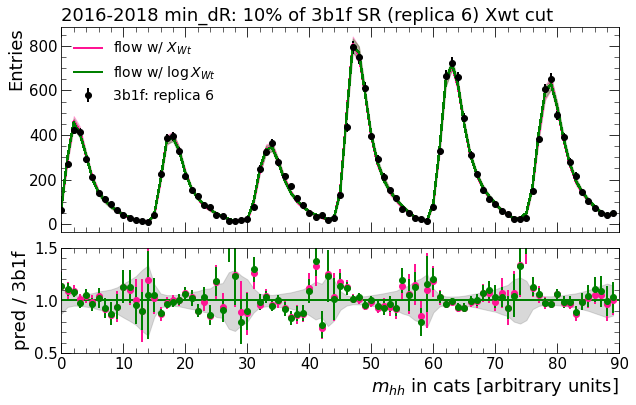

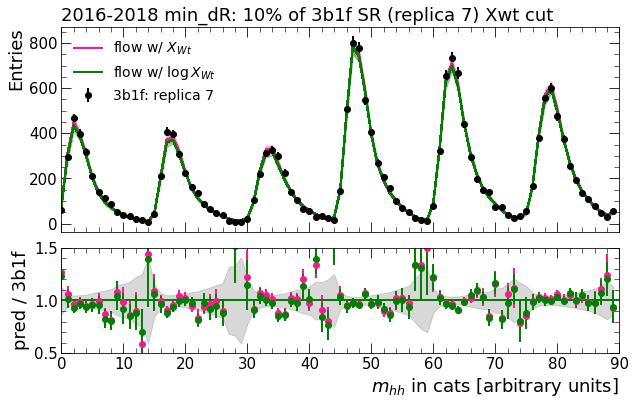

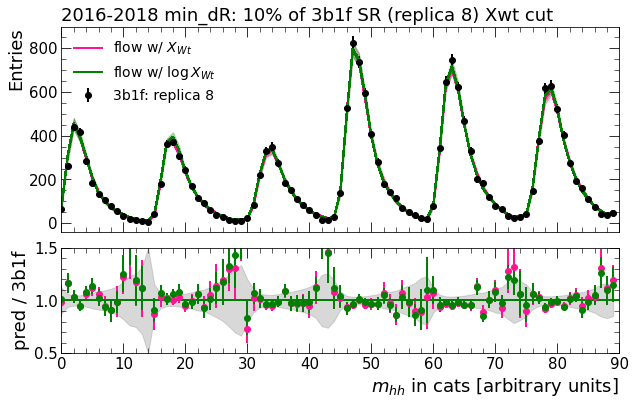

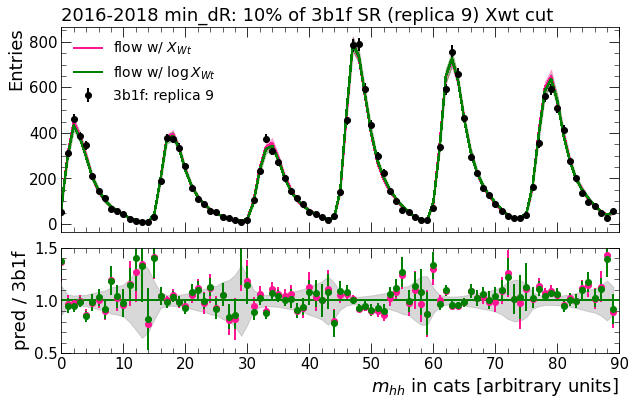

In [146]:
for k, cutStr in zip(['_SR','_SR_Xwt_cut'],['',f'X_wt_tag > 1.5 & ']):

    for i in range(10):

        fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})

        '''
        Put i the obs poits
        '''
        
        mask = df.eval(cutStr + f'event_number % 10 == {i}')

        h_3d = np.histogramdd(df.loc[mask,d_cols].values, edg_3d)[0].flatten()

        ax1.errorbar(range(len(h_3d)), h_3d, np.sqrt(h_3d), 
                     lw=0, elinewidth=2,marker='o',color='k',
                     label=f'3b1f: replica {i}')

        # I should put poiss err i the subpael
        ax2.fill_between(range(len(h_3d)),
                         1+1/np.sqrt(h_3d), 1-1/np.sqrt(h_3d),
                         color='grey',alpha=0.3)

        
        for hd, c, v in zip([hAll,lAll],['deeppink','green'],['$X_{Wt}$','$\log X_{Wt}$']):
        
        
            nom = hd[i][f'X_hh_dEta_hh_m_hh{k}_mean'].copy()
            std = hd[i][f'X_hh_dEta_hh_m_hh{k}_std'].copy()

            ax1.plot(nom,color=c,label=f'flow w/ {v}',lw=1.5)   

            ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c,alpha=0.3)

            ax2.errorbar(range(len(nom)), nom/h_3d, std/h_3d,
                     lw=0, elinewidth=2,marker='o',color=c)
            
        ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

        ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
        ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
        ax1.set_title(f'2016-2018 min_dR: 10% of 3b1f SR (replica {i}){k[3:].replace("_"," ")}',x=0,loc='left')
        ax2.set_ylabel('pred / 3b1f',fontsize=18)

        ax1.legend()
        ax1.set_xlim(0,90)
        ax2.set_ylim(0.5,1.5)

        figDir = f'figures/data161718-MAY21_3b1f_{i}of10_detaCut_ggf/log_Xwt'
        if not os.path.exists(figDir):
            os.mkdir(figDir)
        plt.savefig(f'{figDir}/m_hh_cats_{k}_cf_log_Xwt.pdf',bbox_inches='tight')
        plt.show()

    #break

Since I want to know what the modelling looks like.. I think it would be judicious to  c.f. the _full_ 3b1f set to remove the observed data fluctuations.

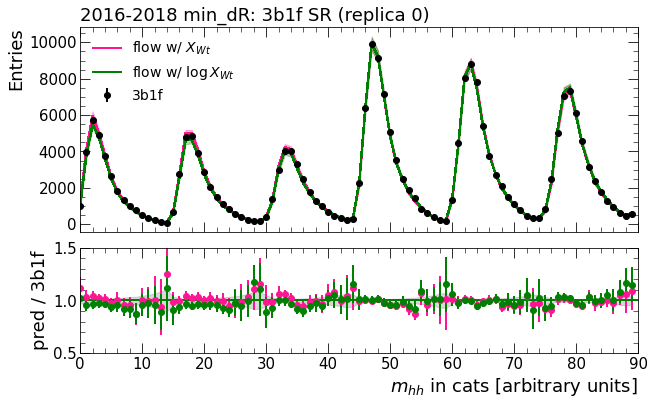

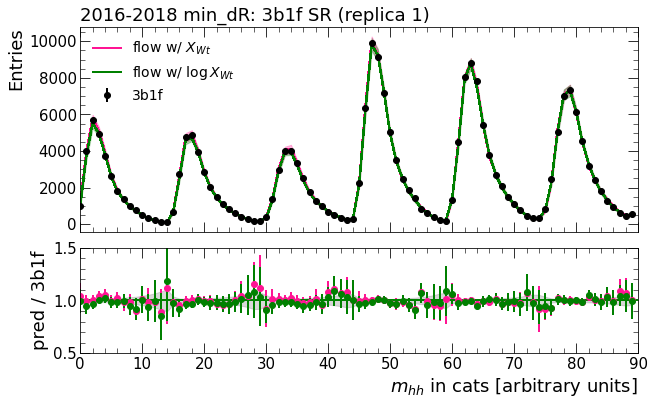

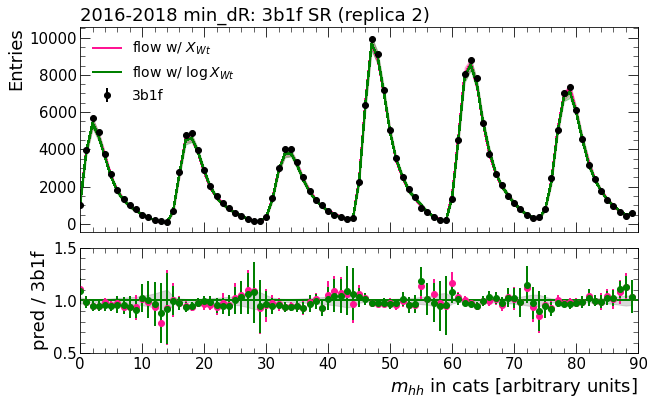

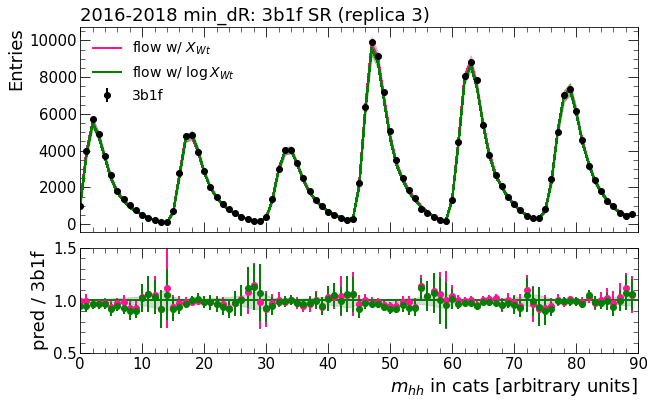

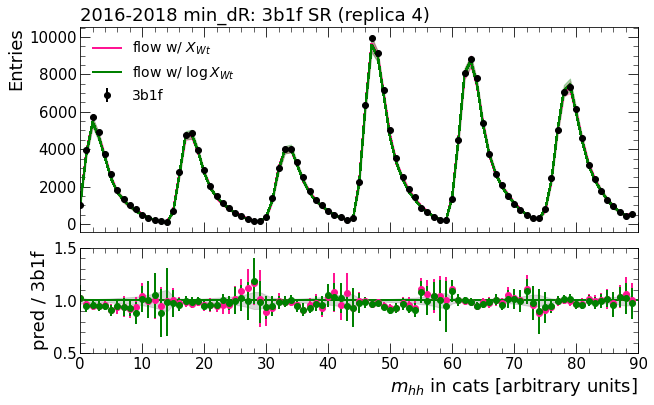

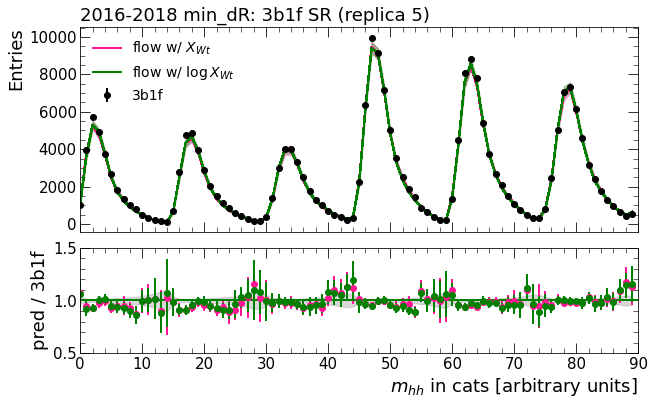

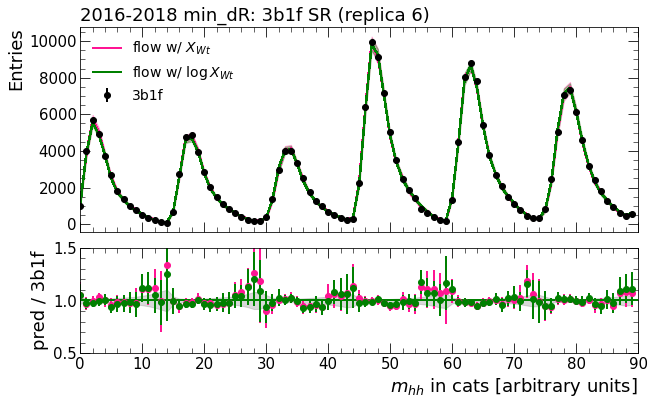

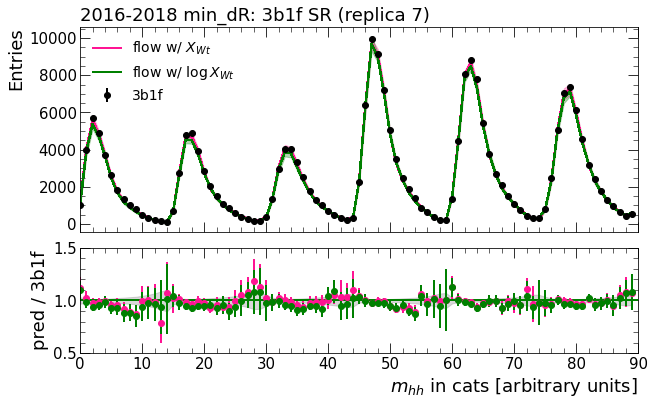

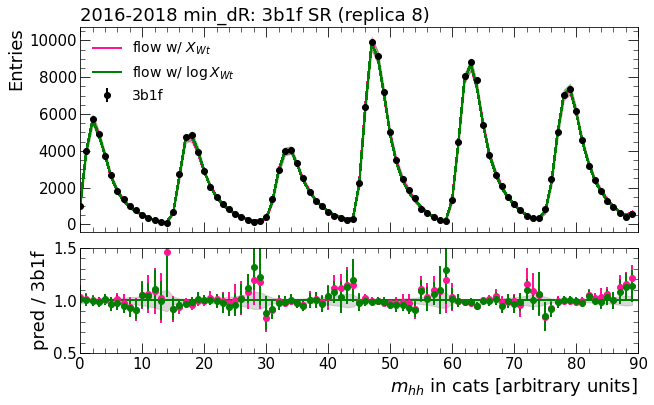

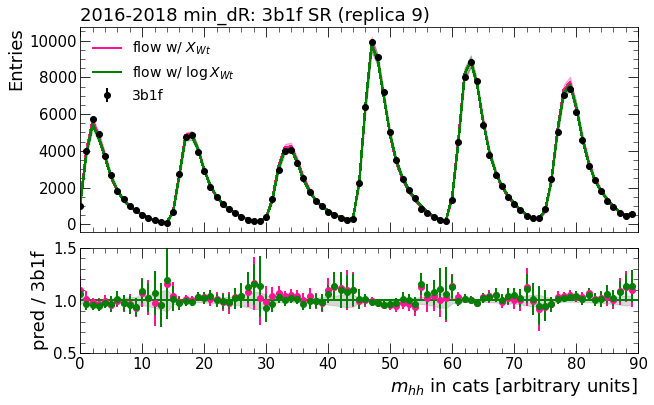

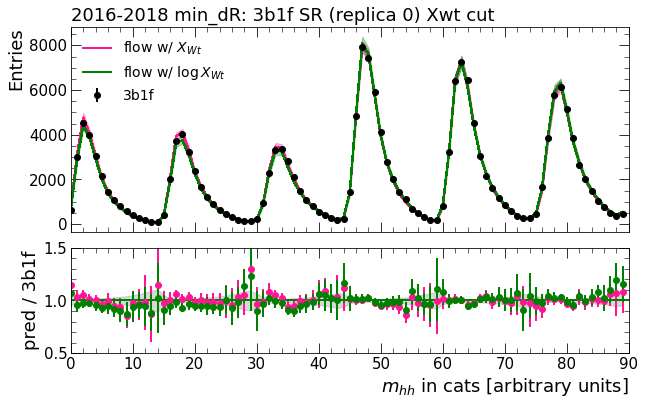

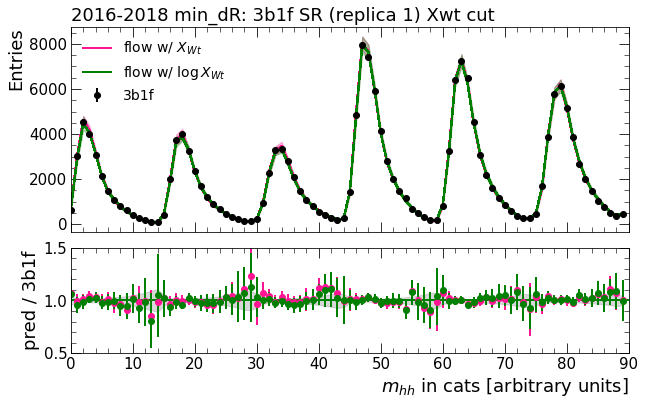

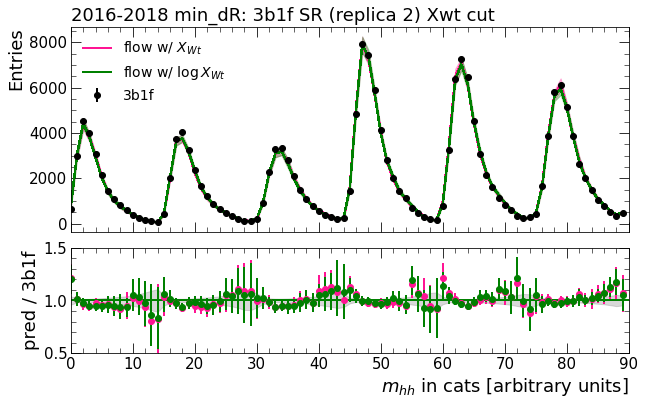

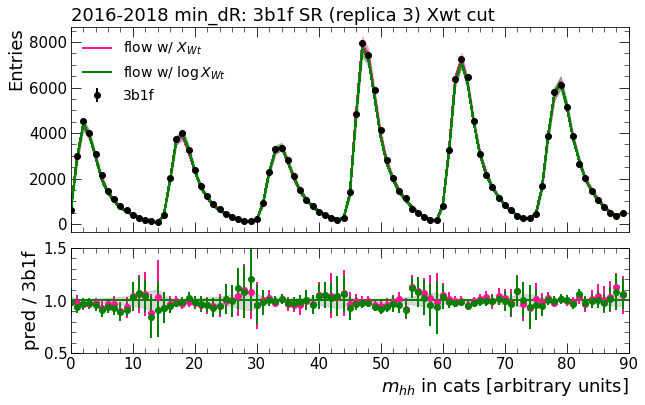

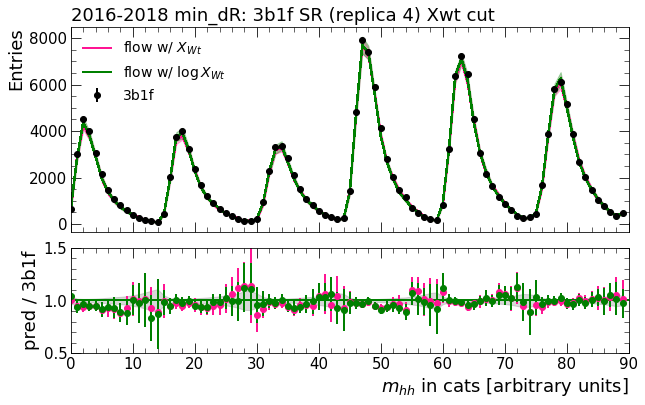

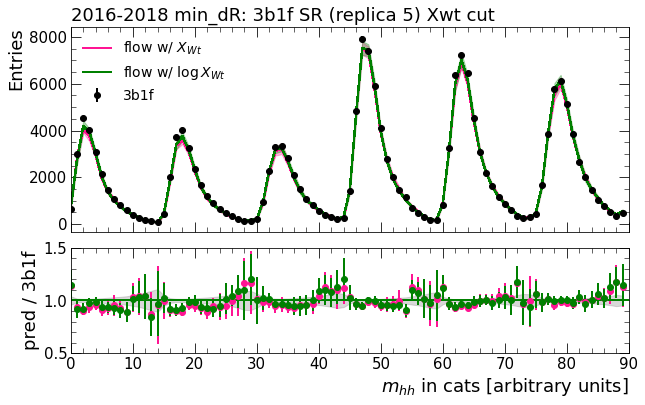

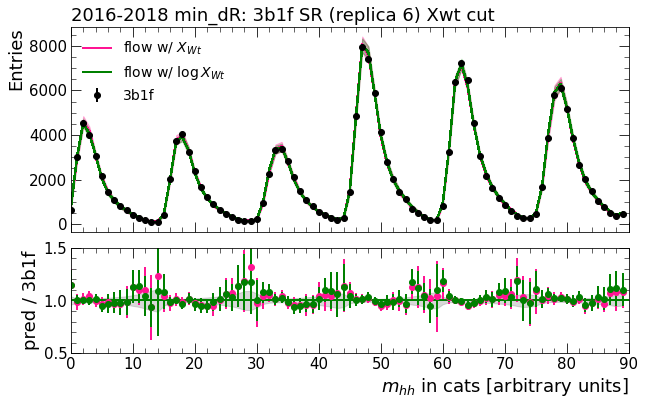

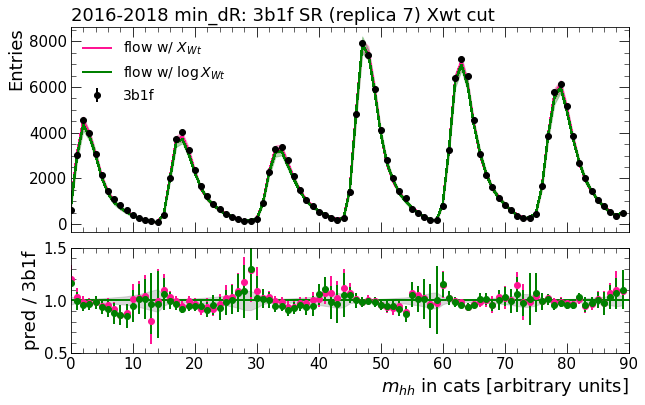

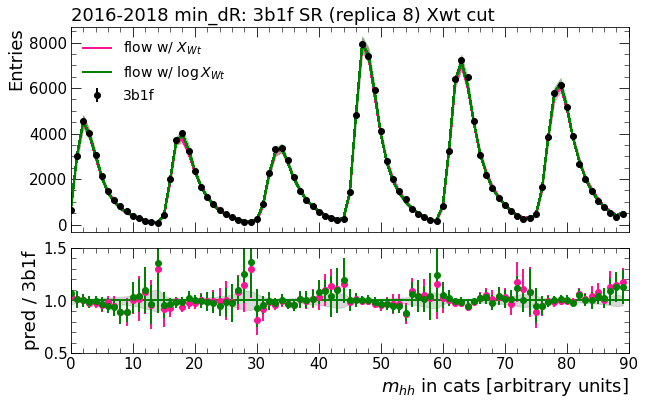

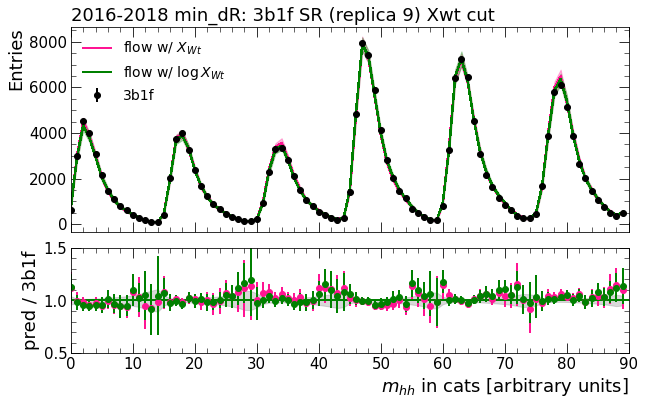

In [202]:
chi2 = {f'{k}:{ki}':[] for k, ki in product(['SR','SR_Xwt_cut'],['X_wt','log_X_wt'])}

for k, cutStr in zip(['_SR','_SR_Xwt_cut'],['',f'X_wt_tag > 1.5']):

    for i in range(10):

        fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})

        '''
        Put i the obs poits
        '''
        if cutStr:
            mask = df.eval(cutStr)
            h_3d = np.histogramdd(df.loc[mask,d_cols].values, edg_3d)[0].flatten()
        else:
            h_3d = np.histogramdd(df[d_cols].values, edg_3d)[0].flatten()

        ax1.errorbar(range(len(h_3d)), h_3d, np.sqrt(h_3d), 
                     lw=0, elinewidth=2,marker='o',color='k',
                     label=f'3b1f')

        # I should put poiss err i the subpael
        ax2.fill_between(range(len(h_3d)),
                         1+1/np.sqrt(h_3d), 1-1/np.sqrt(h_3d),
                         color='grey',alpha=0.3)

        
        for hd, c, v, ki in zip([hAll,lAll],['deeppink','green'],['$X_{Wt}$','$\log X_{Wt}$'],['X_wt','log_X_wt']):
        
        
            nom = hd[i][f'X_hh_dEta_hh_m_hh{k}_mean'].copy()
            std = hd[i][f'X_hh_dEta_hh_m_hh{k}_std'].copy()

            nom *= 10
            std *= 10
            
            
            # Calculate chi^2 to get some aggregation metrics
            chi2_i = np.sum( (h_3d - nom)**2 / nom )
            chi2[f'{k[1:]}:{ki}'].append(chi2_i)
            
            ax1.plot(nom,color=c,label=f'flow w/ {v}',lw=1.5)   

            ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c,alpha=0.3)

            ax2.errorbar(range(len(nom)), nom/h_3d, std/h_3d,
                     lw=0, elinewidth=2,marker='o',color=c)
            
        ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

        ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
        ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
        ax1.set_title(f'2016-2018 min_dR: 3b1f SR (replica {i}){k[3:].replace("_"," ")}',x=0,loc='left')
        ax2.set_ylabel('pred / 3b1f',fontsize=18)

        ax1.legend()
        ax1.set_xlim(0,90)
        ax2.set_ylim(0.5,1.5)

        figDir = f'figures/data161718-MAY21_3b1f_{i}of10_detaCut_ggf/log_Xwt'
        if not os.path.exists(figDir):
            os.mkdir(figDir)
        plt.savefig(f'{figDir}/m_hh_cats_{k}_cf_full_3b1f.pdf',bbox_inches='tight')
        plt.show()

    #break

In [157]:
chi2.keys()

dict_keys(['SR:X_wt', 'SR:log_X_wt', 'SR_Xwt_cut:X_wt', 'SR_Xwt_cut:log_X_wt'])

In [189]:
?plt.hist

3.64812567392113
4.237895654382049


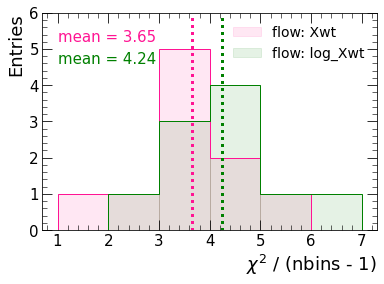

3.534870068072826
3.4429952901209666


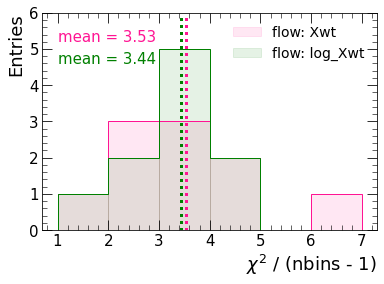

In [200]:
for t in ['','_Xwt_cut']:
    
    for v,c,yloc in zip(['','log_'],['deeppink','green'],[5.2,4.6]):
    
        x = np.array(chi2[f'SR{t}:{v}X_wt'])/89
        
        plt.hist(x,6,(1,7),color=c,edgecolor=c,alpha=.1,label=f'flow: {v}Xwt')
        plt.hist(x,6,(1,7),color=c,histtype='step')
        
        mu = np.mean(x)
        ylim= [0,6]
        plt.plot([mu]*2,ylim,c,ls='dotted')
        print(mu)
        
        plt.text(1,yloc,f'mean = {mu:.2f}',color=c)
        
    plt.xlabel(r'$\chi^2$ / (nbins - 1)',loc='right',fontsize=18)
    plt.ylabel('Entries',loc='top',fontsize=18)
    plt.legend(loc='upper right')
    plt.ylim(ylim)
    
    
    figDir = 'figures/data161718-MAY21_3b1f_0of10_detaCut_ggf/log_Xwt'
    plt.savefig(f'{figDir}/chi2_h3d{t}.pdf',bbox_inches='tight')
    
    plt.show()

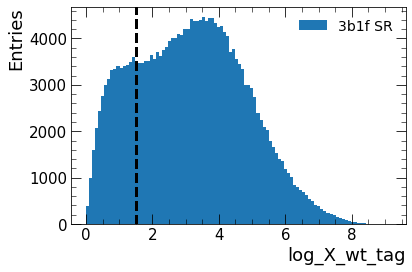

In [64]:
plt.hist(df.loc[~df.pass_vbf_sel,'X_wt_tag'],100,label='3b1f SR')


ylim = plt.ylim()
plt.plot([1.5]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('log_X_wt_tag',loc='right',fontsize=18)
plt.ylabel('Entries',loc='top',fontsize=18)

plt.legend()

plt.show()

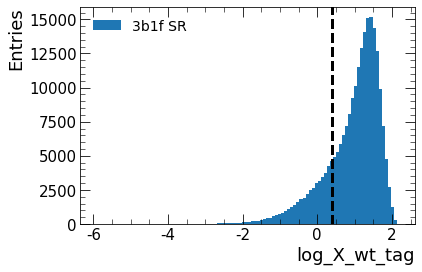

In [65]:
plt.hist(np.log(df['X_wt_tag']),100,label='3b1f SR')

ylim = plt.ylim()
plt.plot([np.log(1.5)]*2,ylim,'k--')
plt.ylim(ylim)

plt.xlabel('log_X_wt_tag',loc='right',fontsize=18)
plt.ylabel('Entries',loc='top',fontsize=18)

plt.legend()

plt.show()

In [203]:
np.log(1.5)

0.4054651081081644

OK - I think it is already clear what I need to do here - the `log_X_wt_tag` modelling variable is _not_ working quite as well.

I think the interesting metric here will be to c.f. the $X_{Wt}$ and $\log X_{Wt}$ modelling across _all_ of the predictions that we have.

**Check `X_wt_tag` + `log_X_wt_tag`**

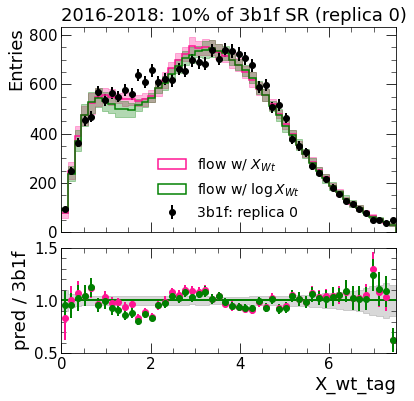

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


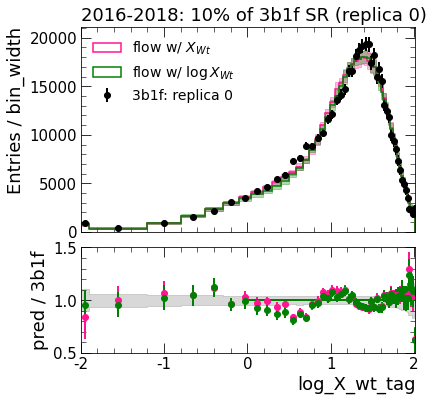

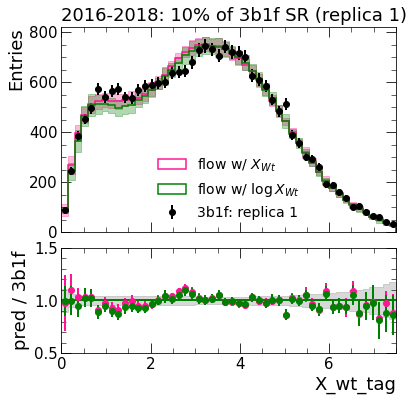

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


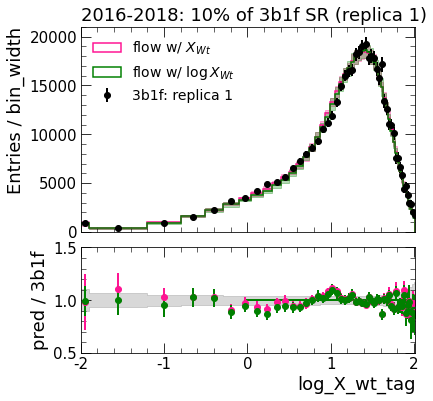

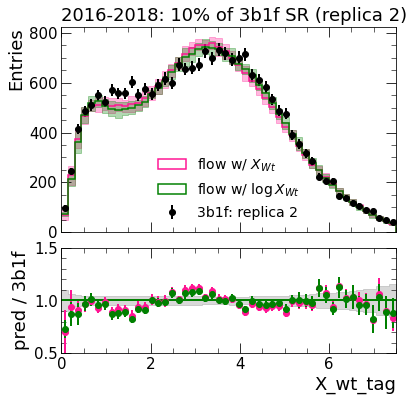

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


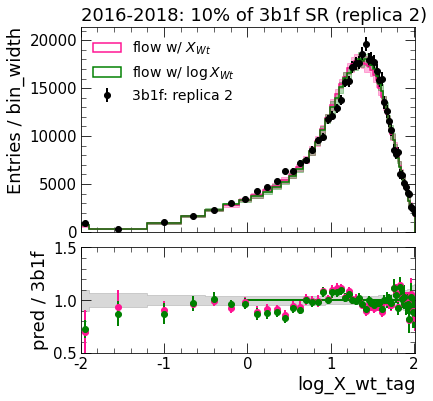

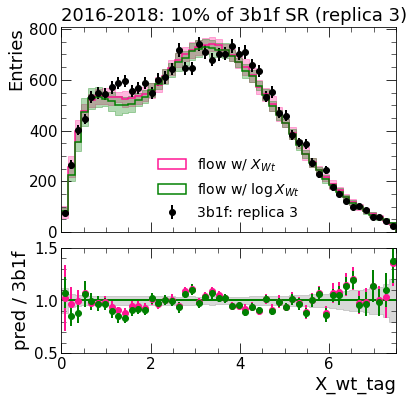

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


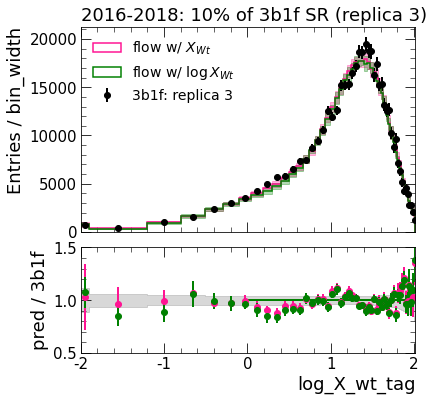

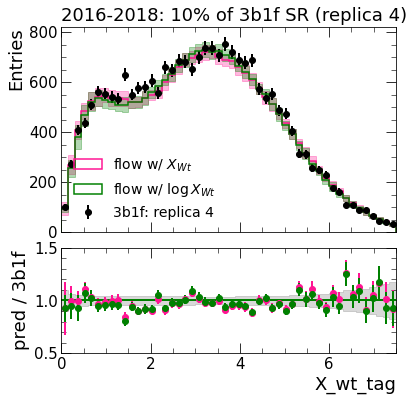

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


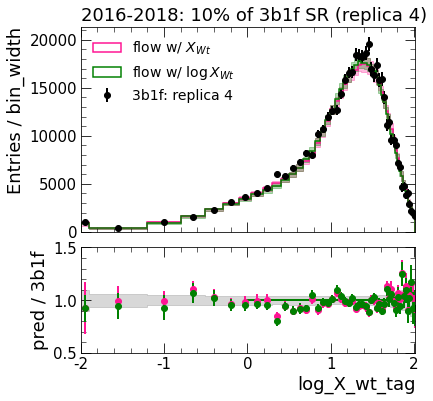

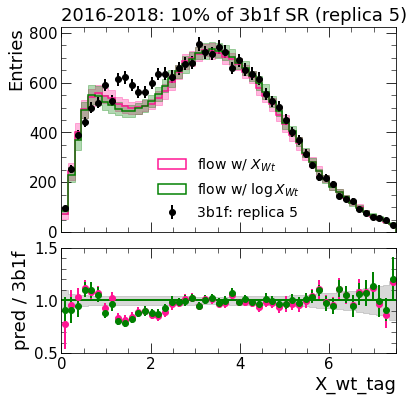

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


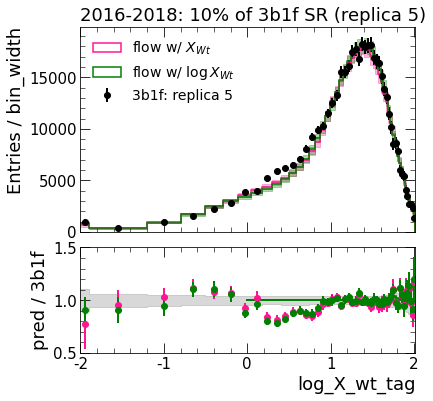

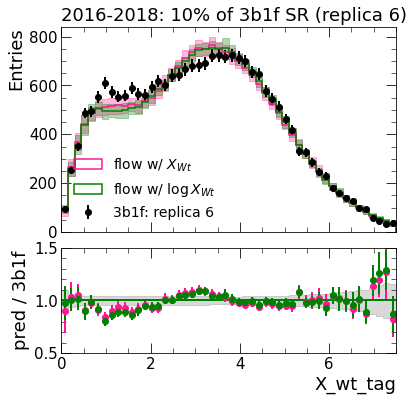

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


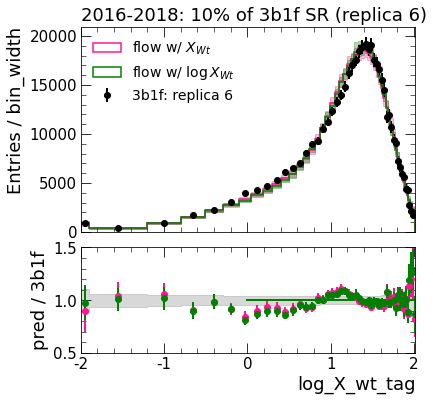

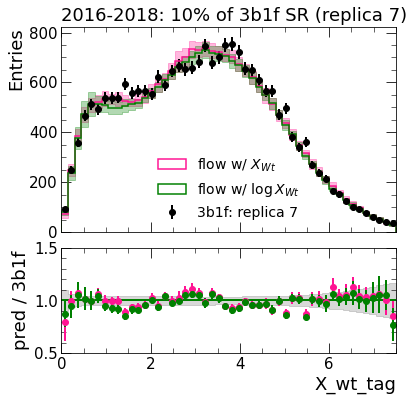

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


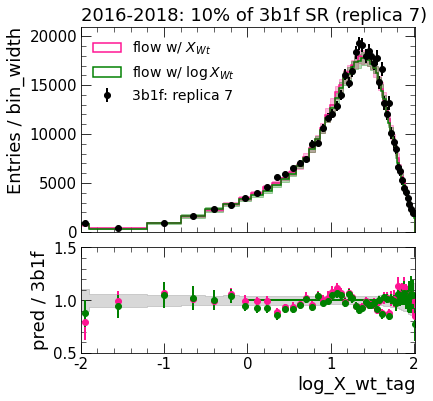

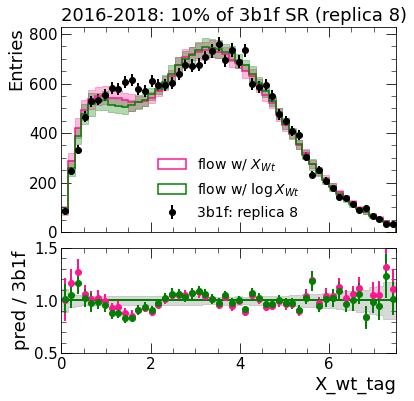

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


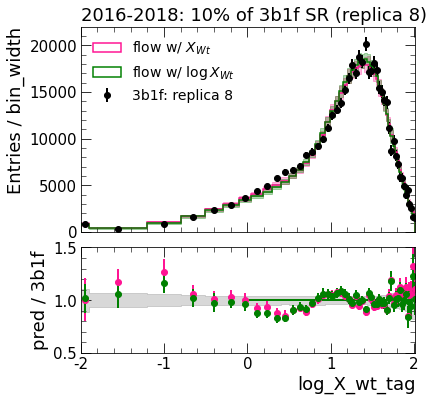

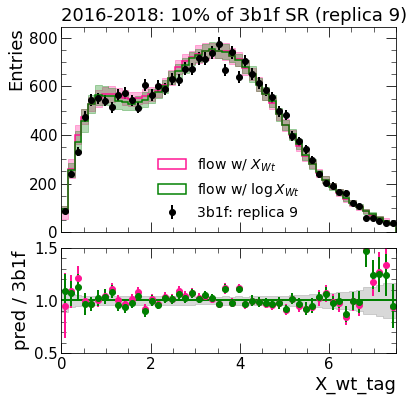

<ipython-input-204-8ac127da769c>:71: RuntimeWarning: divide by zero encountered in log
  ei = np.log(ei)


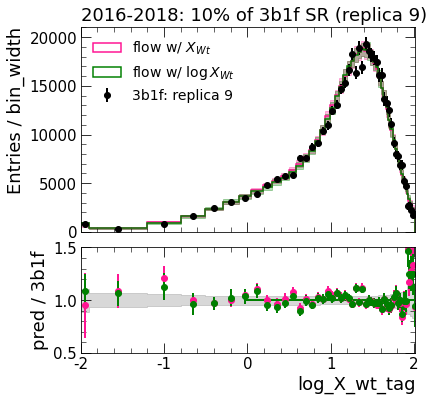

In [204]:
bi = 50
r = (0,7.5)

k='_SR'

for i in range(10):

    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})

    '''
    Put in the obs points
    '''
    mask = df.eval(f'event_number % 10 == {i}')
    hi, ei = np.histogram(df.loc[mask,'X_wt_tag'].values, bi,r)

    xx = 0.5 * (ei[1:] + ei[:-1])
    
    ax1.errorbar(xx, hi, np.sqrt(hi), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f: replica {i}')

    # I should put poiss err i the subpael
    ax2.fill_between(ei, 
                     np.append(1+1/np.sqrt(hi),[0]), 
                     np.append(1-1/np.sqrt(hi),[0]),
                     color='grey',alpha=0.3,step='post')


    for hd, c, v in zip([hAll,lAll],['deeppink','green'],['$X_{Wt}$','$\log X_{Wt}$']):


        nom = hd[i][f'X_wt_tag{k}_mean'].copy()
        std = hd[i][f'X_wt_tag{k}_std'].copy()

        ax1.hist(xx,ei,weights=nom,color=c,label=f'flow w/ {v}',
                 histtype='step',lw=1.5)   

        ax1.fill_between(ei,np.append(nom+std,[0]),np.append(nom-std,[0]),
                         color=c,alpha=0.3,step='post')

        ax2.errorbar(xx, nom/hi, std/hi,
                     lw=0, elinewidth=2,marker='o',color=c)

    ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

    ax2.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 10% of 3b1f SR (replica {i})',x=0,loc='left')
    ax2.set_ylabel('pred / 3b1f',fontsize=18)

    ax1.legend()
    ax1.set_xlim(r)
    ax2.set_ylim(0.5,1.5)

    figDir = f'figures/data161718-MAY21_3b1f_{i}of10_detaCut_ggf/log_Xwt'
    plt.savefig(f'{figDir}/X_wt_tag{k}.pdf',bbox_inches='tight')
    plt.show()

    '''
    And now plot the log(Xwt) variable
    '''
    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})

    '''
    Put in the obs points
    '''
    ei = np.log(ei)
    hi = np.histogram(np.log(df.loc[mask,'X_wt_tag'].values), ei)[0]
    
    ei[0] = -2

    xx = 0.5 * (ei[1:] + ei[:-1])
    
    wi = ei[1:] - ei[:-1]

    ax1.errorbar(xx, hi/wi, np.sqrt(hi)/wi, 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f: replica {i}')

    # I should put poiss err i the subpael
    ax2.fill_between(ei, 
                     np.append(1+1/np.sqrt(hi),[0]), 
                     np.append(1-1/np.sqrt(hi),[0]),
                     color='grey',alpha=0.3,step='post')


    for hd, c, v in zip([hAll,lAll],['deeppink','green'],['$X_{Wt}$','$\log X_{Wt}$']):


        nom = hd[i][f'X_wt_tag{k}_mean'].copy()
        std = hd[i][f'X_wt_tag{k}_std'].copy()

        ax1.hist(xx,ei,weights=nom/wi,color=c,label=f'flow w/ {v}',
                 histtype='step',lw=1.5)   

        ax1.fill_between(ei,np.append((nom+std)/wi,[0]),np.append((nom-std)/wi,[0]),
                         color=c,alpha=0.3,step='post')

        ax2.errorbar(xx, nom/hi, std/hi,
                     lw=0, elinewidth=2,marker='o',color=c)

    ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

    ax2.set_xlabel('log_X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries / bin_width',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 10% of 3b1f SR (replica {i})',x=0,loc='left')
    ax2.set_ylabel('pred / 3b1f',fontsize=18)

    ax1.legend()
    ax1.set_xlim(ei[[0,-1]])
    ax2.set_ylim(0.5,1.5)

    figDir = f'figures/data161718-MAY21_3b1f_{i}of10_detaCut_ggf/log_Xwt'
    plt.savefig(f'{figDir}/log_X_wt_tag{k}.pdf',bbox_inches='tight')
    plt.show()
    
    #break

**Last summary metric**

Let's try to compress all of the replicas on a single plot!

<ipython-input-232-e413a6cede50>:32: RuntimeWarning: divide by zero encountered in log
  ej = np.log(ei)


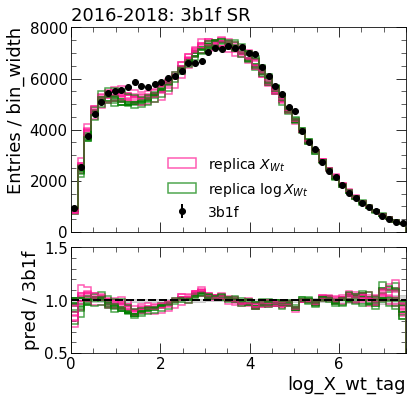

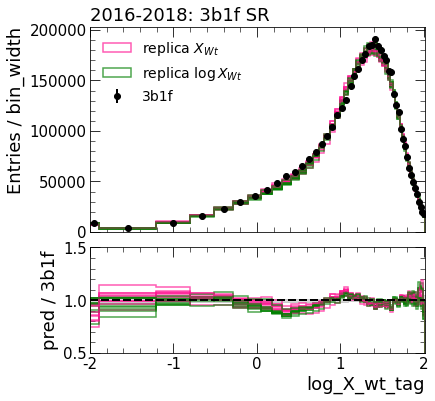

In [232]:
bi = 50
r = (0,7.5)

k='_SR'

fig1, axes1 = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                           gridspec_kw={"height_ratios": [.66,.34],
                                        "hspace":0.1})

fig2, axes2 = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                           gridspec_kw={"height_ratios": [.66,.34],
                                        "hspace":0.1})

'''
Put in the obs points
'''

hi, ei = np.histogram(df['X_wt_tag'].values, bi,r)
xx = 0.5 * (ei[1:] + ei[:-1])

ax1,ax2 = axes1
ax1.errorbar(xx, hi, np.sqrt(hi), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f')

ax2.fill_between(ei, 
                 np.append(1+1/np.sqrt(hi),[0]), 
                 np.append(1-1/np.sqrt(hi),[0]),
                 color='grey',alpha=0.3,step='post')
    
# obs points
ej = np.log(ei)
ej[0] = -2

xj = 0.5 * (ej[1:] + ej[:-1])
wj = ej[1:] - ej[:-1]

ax1,ax2 = axes2
ax1.errorbar(xj, hi/wj, np.sqrt(hi)/wj, lw=0, elinewidth=2,
             marker='o',color='k',label=f'3b1f')

ax2.fill_between(ej,  np.append(1+1/np.sqrt(hi),[0]), 
                 np.append(1-1/np.sqrt(hi),[0]),
                 color='grey',alpha=0.3,step='post')

for i in range(10):

    for hd, c, v in zip([hAll,lAll],['deeppink','green'],['$X_{Wt}$','$\log X_{Wt}$']):


        nom = 10 * hd[i][f'X_wt_tag{k}_mean'].copy()
        
        for (ax1,ax2), x,ee,w in zip([axes1,axes2],[xx,xj],[ei,ej],[1,wj]):
        
            ax1.hist(x,ee,weights=nom/w,color=c,label=f'replica {v}' if i ==0 else None,
                     histtype='step',lw=1.5,alpha=.7)   
            ax2.hist(x, ee, weights=nom/hi, histtype='step',lw=1.5,color=c,alpha=.7)


for (ax1,ax2), ee,loc in zip([axes1,axes2],[ei,ej],['best','upper left']):
    
    ax2.plot(ee[[0,-1]], [1]*2,'k--',lw=2)

    ax2.set_xlabel('log_X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries / bin_width',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 3b1f SR ',x=0,loc='left')
    ax2.set_ylabel('pred / 3b1f',fontsize=18)

    ax1.legend(loc=loc)
    ax1.set_xlim(ee[[0,-1]])
    ax2.set_ylim(0.5,1.5)

figDir = f'figures/data161718-MAY21_3b1f_0of10_detaCut_ggf/log_Xwt'
fig1.savefig(f'{figDir}/X_wt_tag{k}_all_replicas.pdf',bbox_inches='tight')
fig2.savefig(f'{figDir}/log_X_wt_tag{k}_all_replicas.pdf',bbox_inches='tight')

plt.show()
    
